## Combining an ARMA and GARCH model to forecast stock returns


<div class="alert alert-block alert-info">

1. Import dependencies
2. Pre-Processing the Data  
3. Box-Jenkins: Identification
4. Box-Jenkins: Estimation
5. Box-Jenkins: Diagnostic
6. Implementing the GARCH model
7. Forecasting
8. Extra - seasonality     
</div>


###### 1) Import the dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.stats.diagnostic import acorr_ljungbox

from arch import arch_model

from scipy.stats.distributions import chi2
import scipy.stats as scs
from scipy.stats import t

from itertools import product

import warnings

from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

###### 2) Pre-Processing the Data

In [2]:
# Loading web-based data

df = web.get_data_yahoo(tickers="MSFT", start="2018-01-1", end="2022-12-15").reset_index()
df.head(3)

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,86.129997,86.309998,85.500000,85.949997,80.940376,22483800
1,2018-01-03,86.059998,86.510002,85.970001,86.349998,81.317062,26061400
2,2018-01-04,86.589996,87.660004,86.570000,87.110001,82.032791,21912000


In [3]:
# Importing the data 

df['Date']= pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

data = pd.DataFrame(df["Adj Close"])

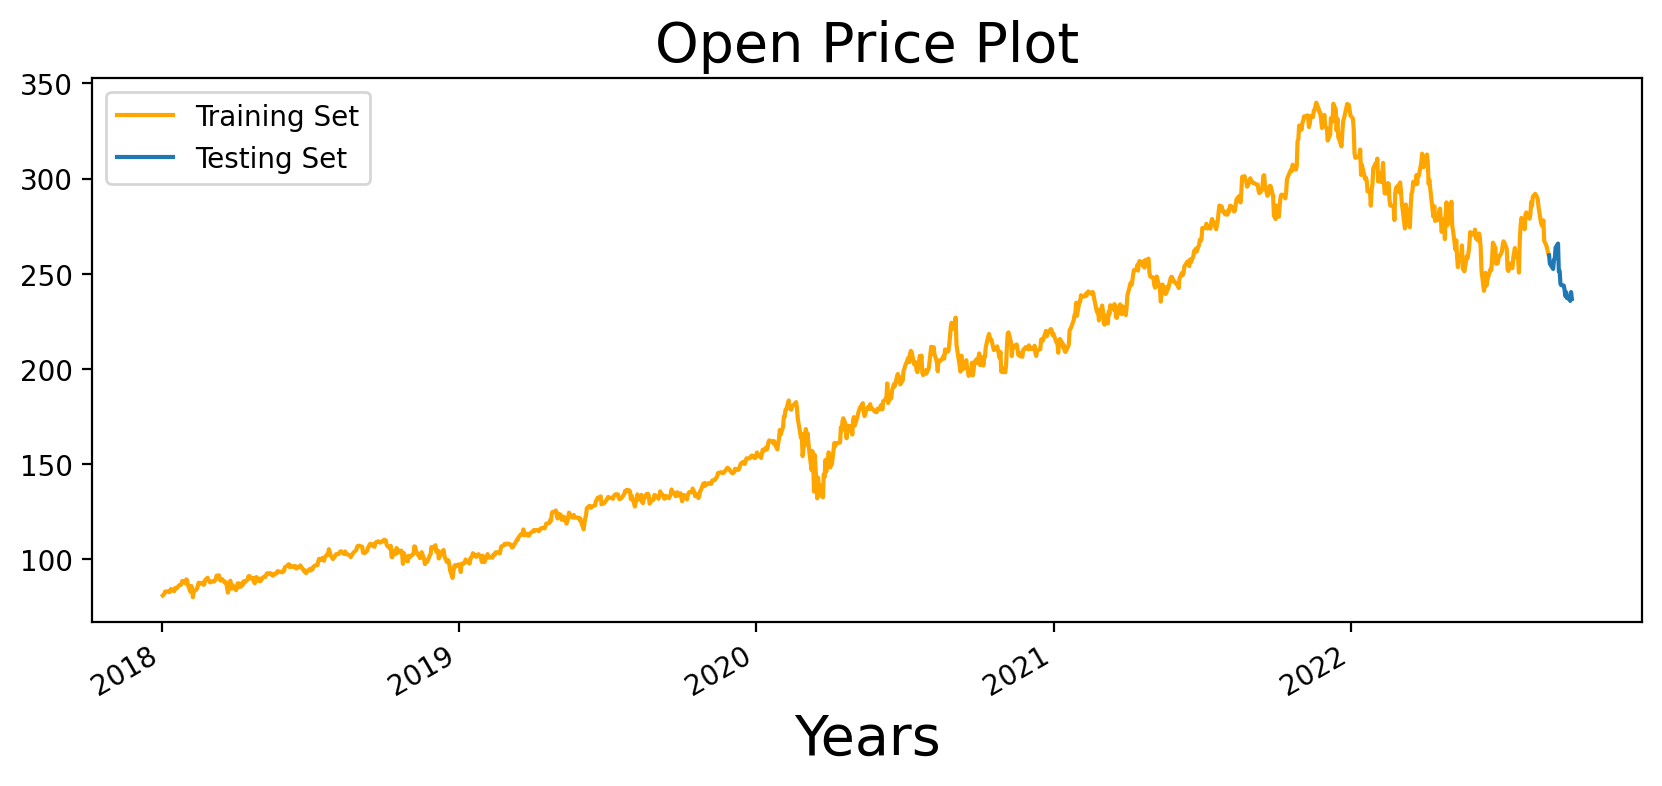

In [4]:
# We plot the Stock Price and the Log Stock Price

# to set the plot size
plt.figure(figsize=(10,4), dpi=200)

# We will forecast the 20 first values after 2021

data.loc[:"2022-08-31"]['Adj Close'].plot(label='Training Set', color='orange')
data.loc["2022-09-01":"2022-09-29"]['Adj Close'].plot(label='Testing Set')

# adding title to the plot
plt.title('Open Price Plot', fontsize=20)

# adding Label to the x-axis
plt.xlabel('Years', fontsize=20)

# adding legend to the curve
plt.legend()

In [5]:
# checking for stationarity with the ADF Test on the Stock Price

def adf_test(data, mode):
    
    if mode == 'ct':
        
        x = adfuller(data, regression='ct', autolag='BIC', store=False, regresults=True)
    elif mode == 'c':
        x = adfuller(data, regression='c', autolag='BIC', store=False, regresults=True)
        
    print(f'ADF Statistic: {x[0]}')
    print(f'Table Value: {list(x[2].values())[0]}')
    print(f'p-value: {x[1]}')

    critical_value = 0.01
    
    if x[1]<critical_value:
        print("We can reject the null hypothesis of non-stationarity: the TS is stationary")
    else:
        print("We cannot reject the null hypothesis of non-stationarity: the TS is not stationary")
    
adf_test(data['Adj Close'], 'ct')

ADF Statistic: -1.7544181538012258
Table Value: -3.9660541106104796
p-value: 0.7263113982079827
We cannot reject the null hypothesis of non-stationarity: the TS is not stationary


In [6]:
adf_test(data['Adj Close'], 'c')

ADF Statistic: -1.189531742845753
Table Value: -3.4356090875394525
p-value: 0.6780826029692895
We cannot reject the null hypothesis of non-stationarity: the TS is not stationary


In [7]:
# We use the log differencing method on our data to make it stationary

data['Log_Returns'] = np.log(data['Adj Close']) - np.log(data['Adj Close'].shift(1))
data.dropna(inplace=True)
data.head()

,Adj Close,Log_Returns
Date,,
2018-01-03,81.317062,0.004643
2018-01-04,82.032791,0.008763
2018-01-05,83.049843,0.012322
2018-01-08,83.134598,0.001020
2018-01-09,83.078072,-0.000680


Text(0, 0.5, 'Log Returns')

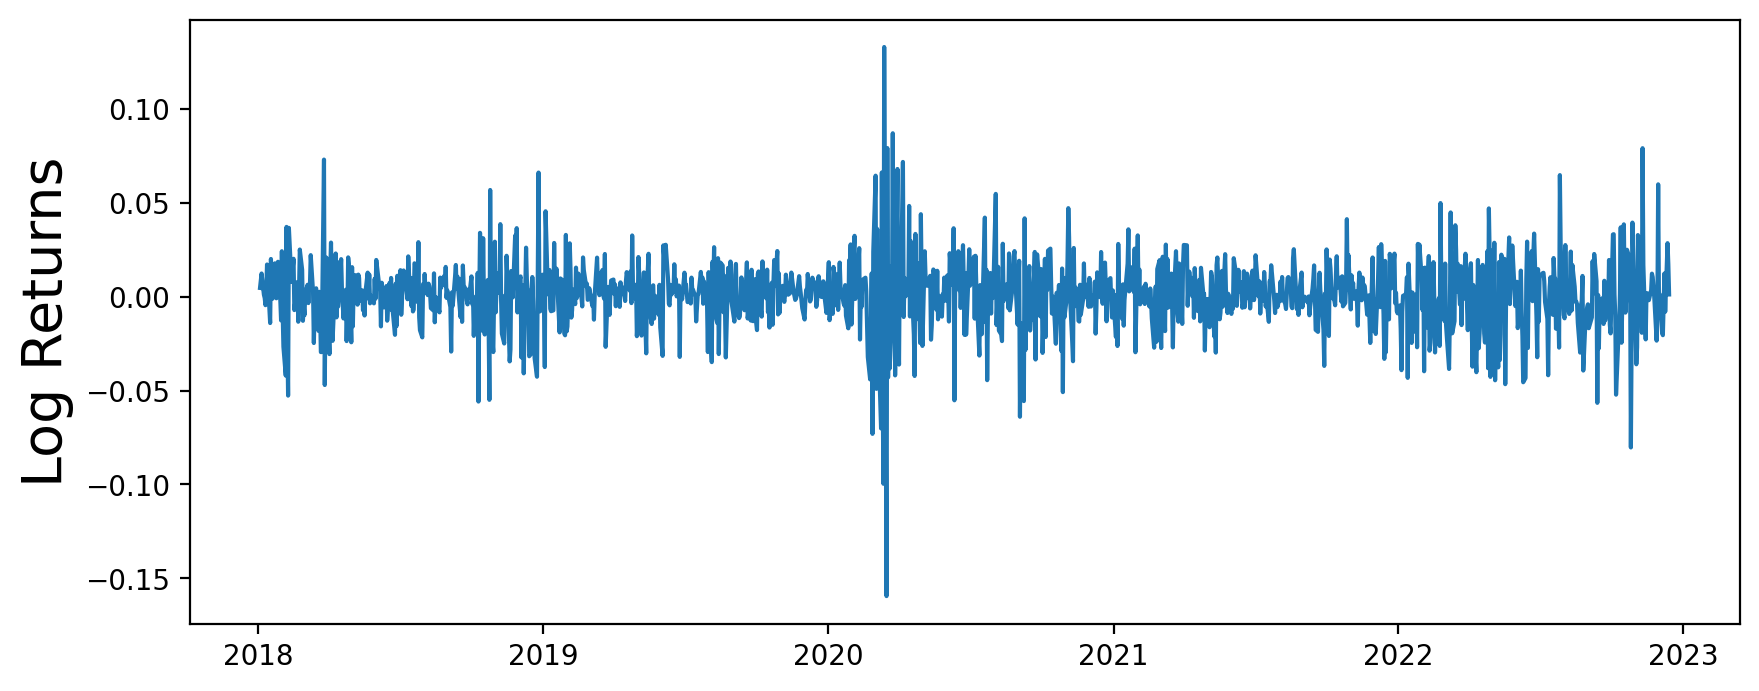

In [8]:
# We plot the log returns 

plt.figure(figsize=(10,4), dpi= 200)
plt.plot(data.Log_Returns)
plt.ylabel('Log Returns', fontsize=20)

In [9]:
# checking for stationarity with the ADF Test on the Log Returns

adf_test(data.Log_Returns, 'c')

ADF Statistic: -43.77228440975609
Table Value: -3.4356090875394525
p-value: 0.0
We can reject the null hypothesis of non-stationarity: the TS is stationary


In [10]:
# creating a training and testing set

train_set = list(data.Log_Returns.loc[:"2022-08-31"] * 100)
test_set = list(data.Log_Returns.loc["2022-09-01":"2022-09-29"] * 100)
full_set = train_set + test_set

In [11]:
# Jarque Bera test: normality of the returns ?

nb_obs = len(full_set)
mw_size = 250

jb_mw = np.zeros(nb_obs-mw_size) 

for x in range(0, nb_obs-mw_size):
    jb = sm.stats.stattools.jarque_bera(full_set[x:mw_size+x], axis =0)
    jb_mw[x]=jb[1] 

np.mean(jb_mw < 0.05) 

0.8432203389830508

We reject $ H_0 $ (Normality of returns) +84% of the time

We will use the Box Jenkins Methodology which can be decomposed in three steps:

- Identification: ACF / PACF plots
- Estimation:
- Diagnostic:


We will first be using our train set before testing our forecast on our test set.


###### 3) Box-Jenkins: Identification

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


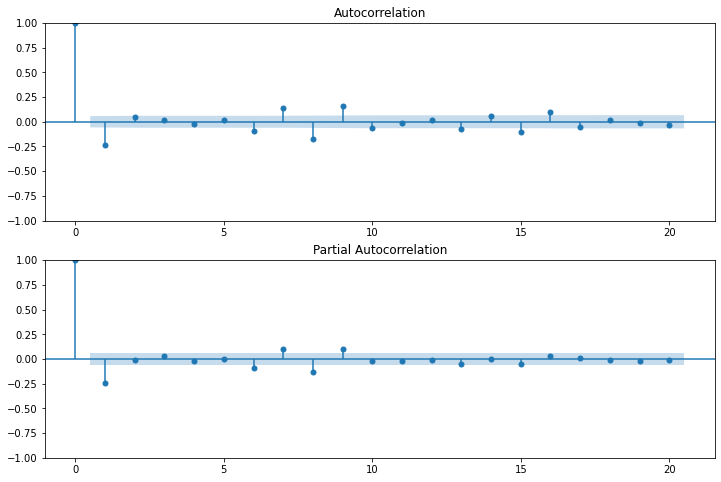

In [12]:
# ACF and PACF plots for Identification

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(train_set, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(train_set, lags=20, ax=ax2)

**ACF**: p=? <br>
**PACF**: q=? <br>
Some autocorr are significantly different from 0. <br>

From these plots it is quite hard to visualise clear Direct and Indirect Autocorrelation as we do not have any significant spikes.

We will therefore base our analysis on information criterias.

In [13]:
# We create the list of ARMA orders that we want to test

ar_order = [0, 1, 2, 3]
ma_order = [0, 1, 2, 3]

arima = [list(orders) for orders in product(ar_order, ma_order)]

# We have to add i=0

for i in range(len(arima)):
    arima[i].insert(1, 0)

In [14]:
# we retrieve the AIC and BIC of each orders

for order in arima:
    print('fitting: ar:{} - i:{} - ma:{}'.format(*order))
    
    try:
        
        arma_model  = ARIMA(train_set, order=order).fit()
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    
    except:
        order.extend([np.NaN, np.NaN])
        

results = pd.DataFrame(arima, columns = ['ar_order', 'i_order', 'ma_order', 'aic', 'bic'])

fitting: ar:0 - i:0 - ma:0
fitting: ar:0 - i:0 - ma:1
fitting: ar:0 - i:0 - ma:2
fitting: ar:0 - i:0 - ma:3
fitting: ar:1 - i:0 - ma:0
fitting: ar:1 - i:0 - ma:1
fitting: ar:1 - i:0 - ma:2
fitting: ar:1 - i:0 - ma:3


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:2 - i:0 - ma:0
fitting: ar:2 - i:0 - ma:1
fitting: ar:2 - i:0 - ma:2
fitting: ar:2 - i:0 - ma:3


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 - i:0 - ma:0
fitting: ar:3 - i:0 - ma:1
fitting: ar:3 - i:0 - ma:2


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 - i:0 - ma:3


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
# We have the following by sorting by BIC

results.sort_values(by='bic').head(3)

,ar_order,i_order,ma_order,aic,bic
14,3,0,2,4.768547,4.804025
10,2,0,2,4.779678,4.810088
9,2,0,1,4.789455,4.814796


In [16]:
# We have the following by sorting by AIC

results.sort_values(by='aic').head(3)

,ar_order,i_order,ma_order,aic,bic
14,3,0,2,4.768547,4.804025
10,2,0,2,4.779678,4.810088
15,3,0,3,4.780264,4.820809


We can see that both AIC and BIC point to the ARMA 3/2

###### 4) Box-Jenkins: Estimation

In [17]:
# We train our ARMA(3,2) on the train set

model = ARIMA(train_set, order=(3,0,2))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1174
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2377.274
Date:                Thu, 29 Dec 2022   AIC                           4768.547
Time:                        22:19:48   BIC                           4804.025
Sample:                             0   HQIC                          4781.926
                               - 1174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0997      0.047      2.119      0.034       0.007       0.192
ar.L1         -1.9269      0.055    -35.173      0.000      -2.034      -1.820
ar.L2         -1.1737      0.074    -15.771      0.0

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###### 5) Box-Jenkins: Diagnostics


We want to check if $\epsilon_t$ is a WN ?

In [18]:
# We Apply the Box Jenkins methodology the residuals of our model

residuals = model_fit.resid

adf_test(residuals, 'c')

ADF Statistic: -34.424639088506396
Table Value: -3.435937099783359
p-value: 0.0
We can reject the null hypothesis of non-stationarity: the TS is stationary


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


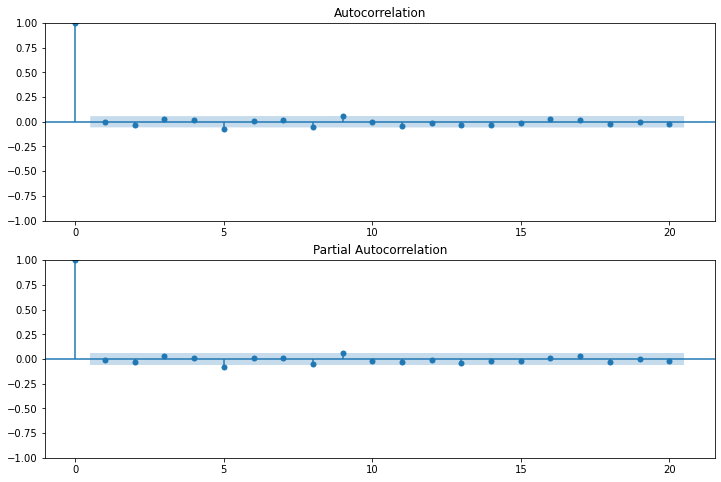

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax2)

In [20]:
# Ljung Box test on residuals

LB = acorr_ljungbox(residuals, lags=range(1,21))
print(np.mean(pd.DataFrame(LB).iloc[1] < 0.05))
print('Thus, there is no autocorrelation in the residuals.')

0.0
Thus, there is no autocorrelation in the residuals.


In [21]:
# We do the same on squarred residuals to visualise potential ARCH effects

residuals_2 = residuals ** 2
adf_test(residuals_2, 'c')

ADF Statistic: -6.5235015059348385
Table Value: -3.4359803948357723
p-value: 1.0281771906392568e-08
We can reject the null hypothesis of non-stationarity: the TS is stationary


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


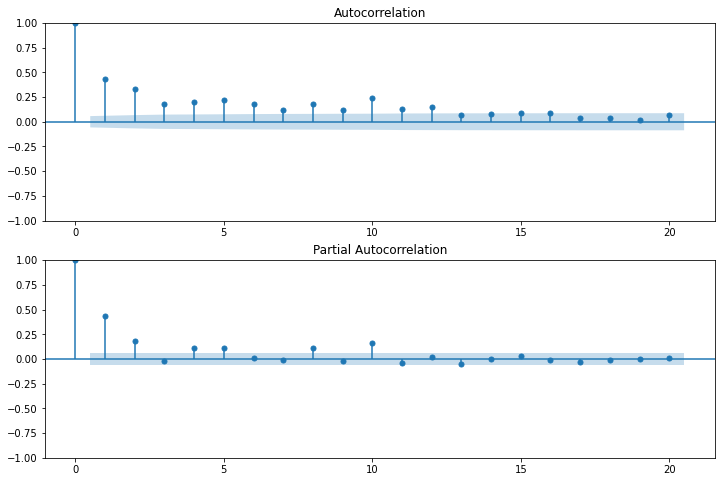

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = sm.graphics.tsa.plot_acf(residuals_2, lags=20, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = sm.graphics.tsa.plot_pacf(residuals_2, lags=20, ax=ax2)

As we see above we find evidence of autocorrelation of residuals, which confirms our idea of volatility clustering in the return graph.

In [23]:
# We perform the Engle's ARCH Test

print(f'p-value: {het_arch(residuals_2)[1]}')
print('We have statistical evidence of our claim')

p-value: 9.462734515071505e-78
We have statistical evidence of our claim


###### 6) Implementing the GARCH Model on residuals

In [24]:
# GARCH model : constrained

VolModel_GARCH = arch_model(train_set, mean='AR', vol='GARCH', lags=1, p=1, o=0, q=1, dist='Normal')
VolModel_GARCH_results = VolModel_GARCH.fit() 

conditional_volatility_GARCH = VolModel_GARCH_results.conditional_volatility

VolModel_GARCH_results.params
VolModel_GARCH_results.summary

#all coeff significant

Iteration:      1,   Func. Count:      7,   Neg. LLF: 975500.7758898388
Iteration:      2,   Func. Count:     17,   Neg. LLF: 13016.977457694997
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1079934.1159478796
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2381.2984280734713
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2699.8686983634966
Iteration:      6,   Func. Count:     51,   Neg. LLF: 2234.176187802933
Iteration:      7,   Func. Count:     59,   Neg. LLF: 2228.995072165285
Iteration:      8,   Func. Count:     66,   Neg. LLF: 2227.973618924289
Iteration:      9,   Func. Count:     72,   Neg. LLF: 2227.973096323591
Iteration:     10,   Func. Count:     78,   Neg. LLF: 2227.9730445119703
Iteration:     11,   Func. Count:     84,   Neg. LLF: 2227.973043507791
Iteration:     12,   Func. Count:     89,   Neg. LLF: 2227.973043507841
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2227.973043507791
            Iterations:

<bound method ARCHModelResult.summary of                            AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -2227.97
Distribution:                  Normal   AIC:                           4465.95
Method:            Maximum Likelihood   BIC:                           4491.28
                                        No. Observations:                 1173
Date:                Thu, Dec 29 2022   Df Residuals:                     1171
Time:                        22:19:48   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.173

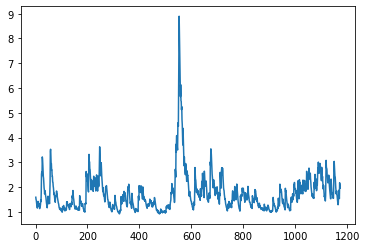

In [25]:
# conditional volatility 

plt.plot(conditional_volatility_GARCH)

Lets also check for leverage effect:
    
We compare $GARCH(1,1)$ (constrained) vs. $GJR(1,1)$ (unconstrained)

In [26]:
# GJR model: unconstrained

VolModel_GJR = arch_model(train_set, mean='AR', vol='GARCH', lags=1, p=1, o=1, q=1, dist='Normal')
VolModel_GJR_results = VolModel_GJR.fit() 

conditional_volatility_GJR = VolModel_GJR_results.conditional_volatility

VolModel_GJR_results.params
VolModel_GJR_results.summary

# all coeff significant including the gamma

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1351484.8811720707
Iteration:      2,   Func. Count:     19,   Neg. LLF: 39903777931.345764
Iteration:      3,   Func. Count:     29,   Neg. LLF: 17342004658.004753
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3265.0693686757586
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2661.6210132112806
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2350.513832469579
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2218.8802093736363
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2217.487490998682
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2217.1184060398778
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2217.1097725329055
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2217.109464228318
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2217.109454984041
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2217.10945498387
Optimization terminated successfully    (Exit mode 0)
   

<bound method ARCHModelResult.summary of                          AR - GJR-GARCH Model Results                         
Dep. Variable:                      y   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.036
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2217.11
Distribution:                  Normal   AIC:                           4446.22
Method:            Maximum Likelihood   BIC:                           4476.62
                                        No. Observations:                 1173
Date:                Thu, Dec 29 2022   Df Residuals:                     1171
Time:                        22:19:48   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.120

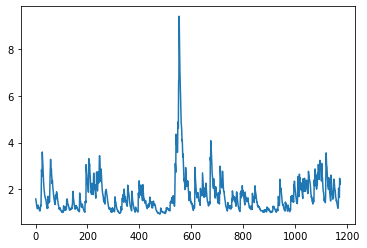

In [27]:
# conditional volatility 

plt.plot(conditional_volatility_GJR)

In [28]:
# Likelihood ratio

LR = 2*(VolModel_GJR_results.loglikelihood - VolModel_GARCH_results.loglikelihood)

alpha = 0.01
quantile_chi2 = scs.chi2.ppf(1-alpha,1)
print(f'Rejection: {LR > quantile_chi2}')

Rejection: True


**Likelihood ratio**: We reject the constrained model as $ LR > \chi_m(1-\alpha) $  --> We will use the unconstrained model (GJR model)


### Conclusion

<div class="alert alert-block alert-info">

**MODEL**

$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \phi_3 y_{t-3} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \epsilon_t$ ~ $ARMA(3/2)$
<br>
where $\epsilon_t = \sigma_t z_t$
<br>
and $\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \gamma I_{t-1} \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$ ~ $GJR(1,1)$

</div>


###### 7) Forecasting all values directly

In [29]:
# We train our ARMA(3,2) on the train set

model = ARIMA(train_set, order=(3,0,2))
model_fit = model.fit()

# Forecast the mean equation

arima_forecast = model_fit.forecast(20)
arima_forecast

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 0.53134656, -0.35637702,  0.56420757, -0.31918204,  0.42437103,
       -0.09789363,  0.15698804,  0.17679543, -0.0888557 ,  0.36480701,
       -0.20028777,  0.39259571, -0.14884748,  0.27615073,  0.01134364,
        0.0970877 ,  0.18434713, -0.04809288,  0.2856171 , -0.09657486])

In [30]:
# Forecast the variance equation using GJR model

forecast_res = np.sqrt(VolModel_GJR_results.forecast(horizon=20, reindex=False).variance) * np.random.normal(0, 1, (1,20))

forecast_res = list(forecast_res.values)
forecast_res

[array([ 3.51507536,  2.78045419, -3.41511714,  1.36653736, -1.2877048 ,
         2.22486021,  5.07279525,  0.52270394, -0.19115689, -0.76915075,
        -1.67265432, -0.52583428,  1.07020084,  0.2229696 ,  0.93757149,
        -0.43317649, -0.30238217,  2.24232578,  2.49251924,  1.88143744])]

<AxesSubplot:>

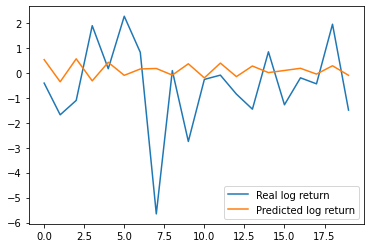

In [31]:
# Forecast without GJR

df_forecast = pd.DataFrame({'Real log return' : test_set,
                            'Predicted log return' : arima_forecast})
  
df_forecast.plot()

In [32]:
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

print(f"RMSE is :{rmse(df_forecast['Predicted log return'],df_forecast['Real log return'])}")

RMSE is :1.8909309269091519


<AxesSubplot:>

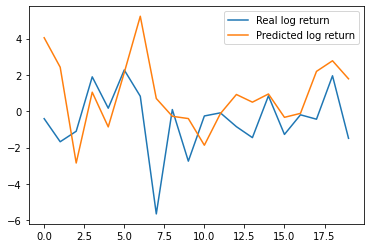

In [33]:
# Forecast with GJR

df_forecast = pd.DataFrame({'Real log return' : test_set,
                            'Predicted log return' : arima_forecast})

for i in range(20):
    df_forecast['Predicted log return'][i] += forecast_res[0][i]
    
df_forecast.plot()

In [34]:
print(f"RMSE is :{rmse(df_forecast['Predicted log return'],df_forecast['Real log return'])}")

RMSE is :2.6056578212666417


###### 8) Forecasting using updated values on the train set

In [35]:
new_train_set = train_set
model_predictions = []

for i in range(len(test_set)):
    
    model_fit = ARIMA(new_train_set, order=(3,0,2)).fit()
    arima_forecast = model_fit.forecast(1)
      
    VolModel_GJR_results = arch_model(train_set, mean='AR', vol='GARCH', lags=1, p=1, o=1, q=1, dist='Normal').fit()
    forecast_res = np.sqrt(VolModel_GJR_results.forecast(horizon=1, reindex=False).variance) * np.random.normal(0, 1)
    
    model_predictions.append(arima_forecast + forecast_res)
    
    new_train_set.append(test_set[i])

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1351484.8811720707
Iteration:      2,   Func. Count:     19,   Neg. LLF: 39903777931.345764
Iteration:      3,   Func. Count:     29,   Neg. LLF: 17342004658.004753
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3265.0693686757586
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2661.6210132112806
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2350.513832469579
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2218.8802093736363
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2217.487490998682
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2217.1184060398778
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2217.1097725329055
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2217.109464228318
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2217.109454984041
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2217.10945498387
Optimization terminated successfully    (Exit mode 0)
   

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1308426.279544601
Iteration:      2,   Func. Count:     19,   Neg. LLF: 63783815580.90201
Iteration:      3,   Func. Count:     29,   Neg. LLF: 17774472322.188797
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3253.588415934282
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2679.8629074131563
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2355.956009409114
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2222.1810113038664
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2221.489691420255
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2220.829977915002
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2220.8218199527655
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2220.821542761038
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2220.821535562066
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2220.8215355616485
Optimization terminated successfully    (Exit mode 0)
     

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1329076.5568951108
Iteration:      2,   Func. Count:     19,   Neg. LLF: 98785713374.80522
Iteration:      3,   Func. Count:     29,   Neg. LLF: 17621176513.85694
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3265.712428197806
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2680.3748018554925
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2364.0359679918015
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2226.0842455932643
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2225.2372701157747
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2224.621771138853
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2224.613312756893
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2224.6130063881783
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2224.612997615902
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2224.6129976154475
Optimization terminated successfully    (Exit mode 0)
   

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1416566.724932822
Iteration:      2,   Func. Count:     19,   Neg. LLF: 52874495962.30561
Iteration:      3,   Func. Count:     29,   Neg. LLF: 16846928952.58437
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3299.5779324742266
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2662.938457829273
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2372.204282231702
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2230.4623641334238
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2228.740235756786
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2228.418479360169
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2228.409275257917
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2228.408879857445
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2228.408866052503
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2228.408866052291
Optimization terminated successfully    (Exit mode 0)
        

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1483900.6516653835
Iteration:      2,   Func. Count:     19,   Neg. LLF: 171800514372.37137
Iteration:      3,   Func. Count:     29,   Neg. LLF: 16352576235.526861
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3319.2398400858947
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2649.3573584201495
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2378.591093841812
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2232.3992347357685
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2230.2311093611092
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2229.988842140445
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2229.9789274343025
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2229.9784531741293
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2229.978435807222
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2229.9784358072084
Optimization terminated successfully    (Exit mode 0)


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 681669.6577987369
Iteration:      2,   Func. Count:     19,   Neg. LLF: 182626595761.84113
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19294195179.38482
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3245.3087631478516
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2717.3306751281098
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2336.036535929534
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2240.488309539958
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2241.631450432057
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2240.238070876182
Iteration:     10,   Func. Count:     87,   Neg. LLF: 2240.1848192321822
Iteration:     11,   Func. Count:     94,   Neg. LLF: 2240.1840777105285
Iteration:     12,   Func. Count:    101,   Neg. LLF: 2240.184056761883
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2240.18405676257
Optimization terminated successfully    (Exit mode 0)
      

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 675770.0874542546
Iteration:      2,   Func. Count:     19,   Neg. LLF: 188066707937.89954
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19727780013.022285
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3223.2039425404323
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2717.7538316677446
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2331.372921896157
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2242.8179213040203
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2242.9284119324693
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2242.854406506629
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2242.6543067895545
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2242.6541732709693
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2242.6541719064353
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2242.6541719062916
Optimization terminated successfully    (Exit mode 0)


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 680233.9607784986
Iteration:      2,   Func. Count:     19,   Neg. LLF: 48672704079.13431
Iteration:      3,   Func. Count:     29,   Neg. LLF: 17087076537.965084
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3240.5597476592575
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2723.8615979021906
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2339.8311253984193
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2244.857283785635
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2245.0894310720796
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2244.8131407723076
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2244.6660109830445
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2244.665775010825
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2244.665772958624
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2244.6657729588105
Optimization terminated successfully    (Exit mode 0)
  

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1250874.4230346093
Iteration:      2,   Func. Count:     19,   Neg. LLF: 90158337067.54185
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19402397617.15257
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3262.140000803781
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2727.635903220233
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2351.3860017193283
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2246.852008070381
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2247.694454329244
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2246.6426642630922
Iteration:     10,   Func. Count:     87,   Neg. LLF: 2246.5674365148625
Iteration:     11,   Func. Count:     94,   Neg. LLF: 2246.5665540311456
Iteration:     12,   Func. Count:    101,   Neg. LLF: 2246.566520994782
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2246.566520995505
Optimization terminated successfully    (Exit mode 0)
     

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1256599.7400082983
Iteration:      2,   Func. Count:     19,   Neg. LLF: 165031734057.89734
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19405519808.85697
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3261.1007433687037
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2730.120130043668
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2357.551151644679
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2248.775315041461
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2249.760485500785
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2248.535567369817
Iteration:     10,   Func. Count:     87,   Neg. LLF: 2248.4537434384965
Iteration:     11,   Func. Count:     94,   Neg. LLF: 2248.452663394604
Iteration:     12,   Func. Count:    101,   Neg. LLF: 2248.4526213010317
Iteration:     13,   Func. Count:    107,   Neg. LLF: 2248.4526213019526
Optimization terminated successfully    (Exit mode 0)
    

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1260007.5207756928
Iteration:      2,   Func. Count:     19,   Neg. LLF: 162000031595.37668
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19510004564.899834
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3259.295274088405
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2732.7871049124633
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2362.3908936113717
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2250.8165389558335
Iteration:      8,   Func. Count:     72,   Neg. LLF: 2251.9144836754444
Iteration:      9,   Func. Count:     80,   Neg. LLF: 2250.5521436306017
Iteration:     10,   Func. Count:     87,   Neg. LLF: 2250.458456367338
Iteration:     11,   Func. Count:     94,   Neg. LLF: 2250.457098884104
Iteration:     12,   Func. Count:    101,   Neg. LLF: 2250.457041482133
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2250.45704086332
Optimization terminated successfully    (Exit mode 0)
   

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1265404.7945331421
Iteration:      2,   Func. Count:     19,   Neg. LLF: 66189682188.710106
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19404728080.27569
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3262.983337260861
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2734.872594313807
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2370.9411039622964
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2252.703225887578
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2253.7551359927666
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2252.2150241662885
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2252.206241289788
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2252.206061370225
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2252.2060597880118
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2252.206059788018
Optimization terminated successfully    (Exit mode 0)
    

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1271793.7355033995
Iteration:      2,   Func. Count:     19,   Neg. LLF: 74997641557.55962
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19369062566.62308
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3263.6154685709143
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2738.297035559939
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2377.386735109283
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2254.6806517968116
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2255.7015177527146
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2254.052481908974
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2254.042752716805
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2254.042532544464
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2254.0425306365214
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2254.0425306364323
Optimization terminated successfully    (Exit mode 0)
    

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1276832.5055288975
Iteration:      2,   Func. Count:     19,   Neg. LLF: 45130886885.39973
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19379200343.87696
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3264.3564496106933
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2740.7009475961286
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2387.784367764166
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2256.625364294323
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2257.2611182830333
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2255.6755756158973
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2255.6643889285324
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2255.6640886619816
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2255.6640858863757
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2255.6640858861383
Optimization terminated successfully    (Exit mode 0)
 

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1282106.5300897376
Iteration:      2,   Func. Count:     19,   Neg. LLF: 48466022924.76814
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19329047814.872314
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3265.323329587544
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2743.3817218555564
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2398.932794466438
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2258.6922765101003
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2258.5599014029385
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2257.2449840266304
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2257.232165544396
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2257.231766703845
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2257.2317623977283
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2257.231762397322
Optimization terminated successfully    (Exit mode 0)
   

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1279577.4598756025
Iteration:      2,   Func. Count:     19,   Neg. LLF: 57372473897.453514
Iteration:      3,   Func. Count:     29,   Neg. LLF: 19245109949.782547
Iteration:      4,   Func. Count:     38,   Neg. LLF: 3273.2923977734963
Iteration:      5,   Func. Count:     47,   Neg. LLF: 2745.8349867814704
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2396.4425120256356
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2260.6188089436664
Iteration:      8,   Func. Count:     73,   Neg. LLF: 2260.619582224253
Iteration:      9,   Func. Count:     81,   Neg. LLF: 2259.248565167535
Iteration:     10,   Func. Count:     88,   Neg. LLF: 2259.236240246802
Iteration:     11,   Func. Count:     95,   Neg. LLF: 2259.235870451982
Iteration:     12,   Func. Count:    102,   Neg. LLF: 2259.2358661393596
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2259.235866138919
Optimization terminated successfully    (Exit mode 0)
  

<AxesSubplot:>

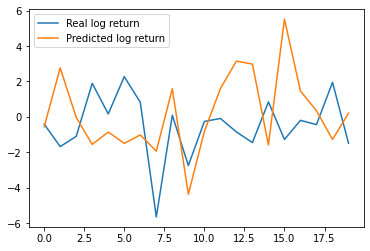

In [36]:
list_of_arrays = [model_predictions[i].values for i in range(len(model_predictions))]
rolling_arima_forecast = []

for array in list_of_arrays:
  for value in array:
    rolling_arima_forecast.append(value[0])


df_results = pd.DataFrame({'Real log return' : test_set,
                            'Predicted log return' : rolling_arima_forecast})

df_results.plot()

In [37]:
print(f"RMSE is :{rmse(df_forecast['Predicted log return'],df_forecast['Real log return'])}")

RMSE is :2.6056578212666417


0.08382229673093043
0.04777870913663034
0.010896898575020955


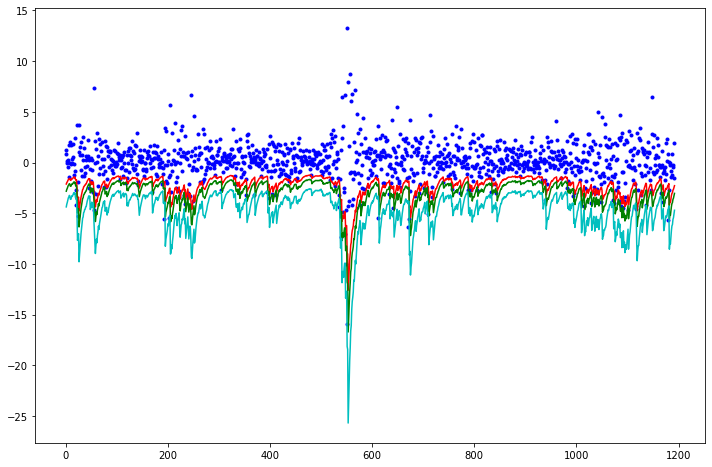

In [38]:
#===========================================================================
# Value-at-Risk estimates
#===========================================================================

var90 = (0.0656 + VolModel_GJR_results.conditional_volatility * t.ppf(0.10,9.2571))
var95 = (0.0656 + VolModel_GJR_results.conditional_volatility * t.ppf(0.05,9.2571)) 
var99 = (0.0656 + VolModel_GJR_results.conditional_volatility * t.ppf(0.01,9.2571)) 
    
fig = plt.figure(figsize=(12,8))
plt.plot(train_set[1:], 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
 
print(np.mean(train_set[1:] < var90))  
print(np.mean(train_set[1:] < var95)) 
print(np.mean(train_set[1:] < var99))

In [39]:
forecast_res = np.sqrt(VolModel_GJR_results.forecast(horizon=20, reindex=False).variance) * np.random.normal(0, 1, (1,20))

0.65
0.65
0.645


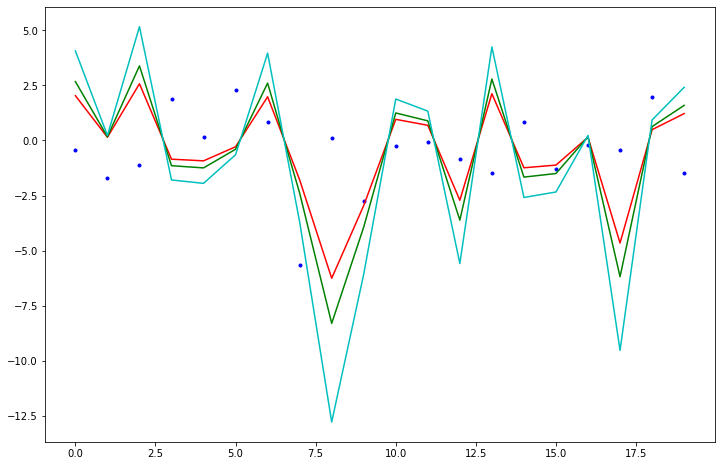

In [40]:
#===========================================================================
# Out of sample VaR forecast
#===========================================================================

var90 = (0.0656 + forecast_res.T.values * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + forecast_res.T.values * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + forecast_res.T.values * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(test_set, 'b.', var90 * 100, 'r-', var95 * 100, 'g-', var99 * 100, 'c-')
 
print(np.mean(test_set < var90))  
print(np.mean(test_set < var95)) 
print(np.mean(test_set < var99))